In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm

In [3]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

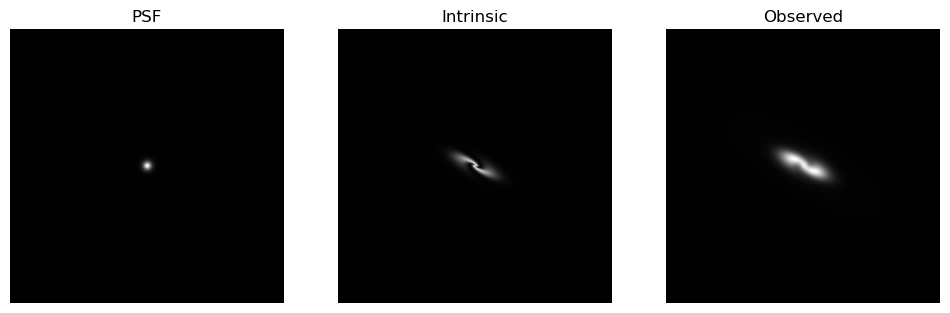

In [4]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

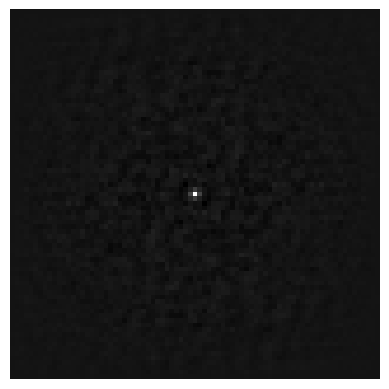

In [50]:
noise = np.random.normal(0, 1, size=(40, 40))
noise = fftconvolve(noise, moffat(width, height, 3.5, 1), mode='same')

# Assume noise is a 2D array
mean_noise = np.mean(noise)
noise_centered = noise - mean_noise

# Estimate 2D autocovariance
autocov = fftconvolve(noise_centered, noise_centered[::-1, ::-1], mode='full') / noise.size
plt.imshow(autocov)
plt.show()

40 40


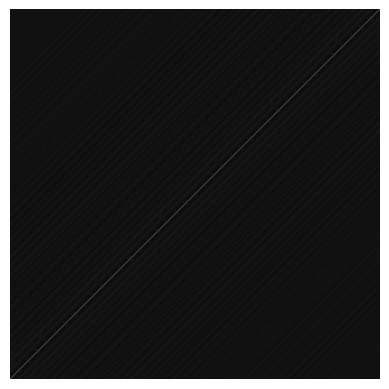

In [48]:
H, W = noise.shape
print(H, W)
num_pixels = H * W
cov_matrix = np.zeros((num_pixels, num_pixels))

cy, cx = np.array(autocov.shape) // 2  # center of autocov map

for i in range(H):
    for j in range(W):
        idx1 = i * W + j
        for m in range(H):
            for n in range(W):
                idx2 = m * W + n
                dy = m - i
                dx = n - j
                cov_matrix[idx1, idx2] = autocov[cy + dy, cx + dx]
plt.imshow(cov_matrix)
plt.show()

In [ ]:
for n in range(H*W):
    

[-0.00011547  0.06197498]
[0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, -0.00011547436239545358, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.06197497635624883, 0.0